In [1]:
import io
from PIL import Image
import io
import glob, sys, time, uuid
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os

%matplotlib inline
from PIL import Image, ImageDraw
from video_indexer import VideoIndexer
from azure.cognitiveservices.vision.face import FaceClient
from azure.cognitiveservices.vision.face.models import TrainingStatusType
from msrest.authentication import CognitiveServicesCredentials
from dotenv import load_dotenv
from pathlib import Path

dotenv_path = Path("../.env")
load_dotenv(dotenv_path=dotenv_path)

True

In [2]:
# Get the environment variable
VIDEO_RECOGNIZER_SUBSCRIPTION_KEY = os.getenv(
    "VIDEO_RECOGNIZER_SUBSCRIPTION_KEY")
VIDEO_RECOGNIZER_ACCOUNT_ID = os.getenv("VIDEO_RECOGNIZER_ACCOUNT_ID")

In [3]:
print(VIDEO_RECOGNIZER_SUBSCRIPTION_KEY)

bbccfdd4fe7d4305924b41aa3965023c


In [4]:
CONFIG = {
    "SUBSCRIPTION_KEY": VIDEO_RECOGNIZER_SUBSCRIPTION_KEY,
    "LOCATION": "trial",
    "ACCOUNT_ID": VIDEO_RECOGNIZER_ACCOUNT_ID,
}
video_analysis = VideoIndexer(
    vi_subscription_key=CONFIG["SUBSCRIPTION_KEY"],
    vi_location=CONFIG["LOCATION"],
    vi_account_id=CONFIG["ACCOUNT_ID"],
)

In [5]:
video_analysis.check_access_token()

Getting video indexer access token...
Access Token: eyJhbGciOiJSUzI1NiIsInR5cCI6IkpXVCJ9.eyJWZXJzaW9uIjoiMi4wLjAuMCIsIktleVZlcnNpb24iOiI1MTBhNTI4NTRiZjg0MDIwOTZhNDZjN2I0ZWY1NTE4OCIsIkFjY291bnRJZCI6ImVmOWZjNzIxLWI2MzYtNDNmYi05MTIzLTU5ZTY2YWJhZTM5ZCIsIkFjY291bnRUeXBlIjoiVHJpYWwiLCJQZXJtaXNzaW9uIjoiQ29udHJpYnV0b3IiLCJFeHRlcm5hbFVzZXJJZCI6IkM0MjQ0ODhDNEZGQzRFODA5NTM5M0E2NjY5MDAxN0Y1IiwiVXNlclR5cGUiOiJNaWNyb3NvZnRDb3JwQWFkIiwiSXNzdWVyTG9jYXRpb24iOiJUcmlhbCIsIm5iZiI6MTcxMzgwMTY0NSwiZXhwIjoxNzEzODA1NTQ1LCJpc3MiOiJodHRwczovL2FwaS52aWRlb2luZGV4ZXIuYWkvIiwiYXVkIjoiaHR0cHM6Ly9hcGkudmlkZW9pbmRleGVyLmFpLyJ9.fsQY4ELU_Hs0SMAvUG0G9AV_iIe0dADAHZ2-hD8iO5JG-f1DFoab1awOZ8poy8kUbH1spULK2o_WpOxdC8ghChicXlhLa_J7U-QWxlajshUtjNtSHpZ7rBWCi9ynP35Eo9ZNCiuRLU43lqH3NSlTH01tDTL_7ReHTjJU1ekJ7Iuxmg9rizGQsvnNSwF36v5nKnqXj1G_jHuh6gf4lKWHseh_WWGTDxOS8-gzG3EIovmjSZkuSOvIlzUhip0xrIaLGNnY_kHqAckxcu06ecFTh0G7VbzngG7Q3meF2xeP77xsO4kVkWMaxtmWiegtT4k3vH3FvXTV9g7OR_Di-TDH3Q


### Upload Video to Video Indexer


In [6]:
uploaded_video_id = video_analysis.upload_to_video_indexer(
    input_filename="avkash-boarding-pass.mp4",
    video_name="avkash-boarding-pass",
    video_language="English",
)

Uploading video to video indexer...


In [7]:
uploaded_video_id

'2beaacef57'

### Extract face thumbnail


In [13]:
info = video_analysis.get_video_info(uploaded_video_id, video_language="English")

Getting video info for: 2beaacef57


In [14]:
info["videos"][0]["insights"]["shots"]

[{'id': 1,
  'tags': ['CloseUp', 'CenterFace'],
  'keyFrames': [{'id': 1,
    'instances': [{'thumbnailId': '1cf6d487-7ed0-4bc9-967b-e21836d92439',
      'adjustedStart': '0:00:00.2672778',
      'adjustedEnd': '0:00:00.3007667',
      'start': '0:00:00.2672778',
      'end': '0:00:00.3007667'}]},
   {'id': 2,
    'instances': [{'thumbnailId': '32e05794-7445-4d78-8121-8ba6bb134737',
      'adjustedStart': '0:00:00.3342556',
      'adjustedEnd': '0:00:00.3677333',
      'start': '0:00:00.3342556',
      'end': '0:00:00.3677333'}]}],
  'instances': [{'adjustedStart': '0:00:00',
    'adjustedEnd': '0:00:26.4998556',
    'start': '0:00:00',
    'end': '0:00:26.4998556'}]}]

In [15]:
keyframes = []
for shot in info["videos"][0]["insights"]["shots"]:
    for keyframe in shot["keyFrames"]:
        keyframes.append(keyframe["instances"][0]["thumbnailId"])

In [16]:
for keyframe in keyframes:
    img_str = video_analysis.get_thumbnail_from_video_indexer(
        uploaded_video_id, keyframe
    )

Getting thumbnail from video: 2beaacef57, thumbnail: 1cf6d487-7ed0-4bc9-967b-e21836d92439


Getting thumbnail from video: 2beaacef57, thumbnail: 32e05794-7445-4d78-8121-8ba6bb134737


In [17]:
thumbnail_id = keyframes[0]

Getting thumbnail from video: 2beaacef57, thumbnail: 1cf6d487-7ed0-4bc9-967b-e21836d92439


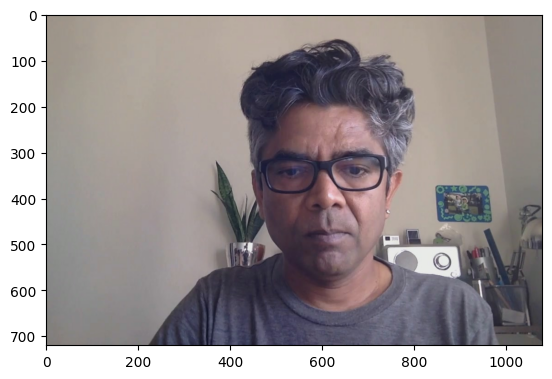

In [18]:
img_code = video_analysis.get_thumbnail_from_video_indexer(
    uploaded_video_id, thumbnail_id
)
img_stream = io.BytesIO(img_code)
img = Image.open(img_stream)
imshow(img)
img.save("videoanalyzer_screenshot.png", "PNG")

### Create Face Recognition Model


In [19]:
images = []
# img_raw = []
img_strs = []
for each_thumb in info["videos"][0]["insights"]["faces"][0]["thumbnails"]:
    if "fileName" in each_thumb and "id" in each_thumb:
        file_name = each_thumb["fileName"]
        thumb_id = each_thumb["id"]
        img_code = video_analysis.get_thumbnail_from_video_indexer(
            uploaded_video_id, thumb_id
        )
        img_strs.append(img_code)
        img_stream = io.BytesIO(img_code)
        # img_raw.append(img_stream)
        img = Image.open(img_stream)
        images.append(img)

i = 1
for img in images:
    print(type(img))
    img.save("face" + str(i) + ".png")
    i = i + 1

Getting thumbnail from video: 2beaacef57, thumbnail: b5584553-edd0-489a-bc3a-e304d9ee4c2c
Getting thumbnail from video: 2beaacef57, thumbnail: 14efc2e6-3d5d-4ef6-a5da-fe73b404733b
Getting thumbnail from video: 2beaacef57, thumbnail: 8e333c70-707c-4905-9a00-c3a9c35e54b2
Getting thumbnail from video: 2beaacef57, thumbnail: 9c009925-2867-4970-93ea-fb067f7c2db9
Getting thumbnail from video: 2beaacef57, thumbnail: bef6125a-103d-42b1-8834-9f1d941c1265
Getting thumbnail from video: 2beaacef57, thumbnail: b413c77a-6cbe-4474-9f20-a5bf2e4a4ad8
Getting thumbnail from video: 2beaacef57, thumbnail: 7a857e3d-4e3d-4ee6-965a-6065d0780d13
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>


In [20]:
# Get the environment variable
FACE_API_KEY = os.getenv("FACE_API_KEY")
FACE_API_ENDPOINT = os.getenv("FACE_API_ENDPOINT")

In [21]:
# Create a client
face_client = FaceClient(FACE_API_ENDPOINT, CognitiveServicesCredentials(FACE_API_KEY))

In [22]:
face_client.api_version

'1.0'

In [23]:
PERSON_GROUP_ID = str(uuid.uuid4())
person_group_name = "avkash-boarding-pass.mp4"

In [24]:
def build_person_group(client, person_group_id, pgp_name):
    print("Create and build a person group...")
    # Create empty Person Group. Person Group ID must be lower case, alphanumeric, and/or with '-', '_'.
    print("Person group ID:", person_group_id)
    client.person_group.create(
        person_group_id=person_group_id, name=person_group_id)
    # Create a person group person.
    human_person = client.person_group_person.create(person_group_id, pgp_name)
    # Find all jpeg human images in working directory.
    human_face_images = [file for file in glob.glob(
        "*.png") if file.startswith("face")]
    # Add images to a Person object
    for image_p in human_face_images:
        with open(image_p, "rb") as w:
            client.person_group_person.add_face_from_stream(
                person_group_id, human_person.person_id, w
            )
    # Train the person group, after a Person object with many images were added to it.
    client.person_group.train(person_group_id)
    # Wait for training to finish.
    while True:
        training_status = client.person_group.get_training_status(
            person_group_id)
        print("Training status: {}.".format(training_status.status))
        if training_status.status is TrainingStatusType.succeeded:
            break
        elif training_status.status is TrainingStatusType.failed:
            client.person_group.delete(person_group_id=PERSON_GROUP_ID)
            sys.exit("Training the person group has failed.")
        time.sleep(5)

In [25]:
build_person_group(face_client, PERSON_GROUP_ID, person_group_name)

Create and build a person group...
Person group ID: caf812af-51bc-484e-915e-bd099c9c42e0
Training status: succeeded.


### Emotion from the video Indexer


In [26]:
video_analysis.get_video_info(uploaded_video_id)

Getting video info for: 2beaacef57


{'partition': None,
 'description': None,
 'privacyMode': 'Private',
 'state': 'Processed',
 'accountId': 'ef9fc721-b636-43fb-9123-59e66abae39d',
 'id': '2beaacef57',
 'name': 'avkash-boarding-pass',
 'userName': 'ODL_User 258139',
 'created': '2024-04-22T16:05:47.82+00:00',
 'isOwned': True,
 'isEditable': True,
 'isBase': True,
 'durationInSeconds': 26,
 'duration': '0:00:26.499856',
 'summarizedInsights': {'name': 'avkash-boarding-pass',
  'id': '2beaacef57',
  'privacyMode': 'Private',
  'duration': {'time': '0:00:26.499856', 'seconds': 26.5},
  'thumbnailVideoId': '2beaacef57',
  'thumbnailId': 'a5d494f0-cfd9-4acc-82a2-bde83829a43e',
  'faces': [{'videoId': '2beaacef57',
    'confidence': 0,
    'description': None,
    'title': None,
    'thumbnailId': '39c53d5b-c784-4795-99ef-ca83b0943218',
    'seenDuration': 26.5,
    'seenDurationRatio': 1,
    'id': 1000,
    'name': 'Unknown #1',
    'appearances': [{'startTime': '0:00:00',
      'endTime': '0:00:26.4998556',
      'startSe

In [27]:
info["summarizedInsights"]["sentiments"]

[{'sentimentKey': 'Neutral',
  'seenDurationRatio': 1,
  'appearances': [{'startTime': '0:00:00',
    'endTime': '0:00:26.499856',
    'startSeconds': 0,
    'endSeconds': 26.5}]},
 {'sentimentKey': 'Negative',
  'seenDurationRatio': 0.0755,
  'appearances': [{'startTime': '0:00:07.72',
    'endTime': '0:00:09.68',
    'startSeconds': 7.7,
    'endSeconds': 9.7}]}]

### Face Extraction From Digital ID


In [28]:
face_id_path = "ca-dl-avkash-chauhan.png"

In [29]:
def show_image_in_cell(face_url):
    img = Image.open(face_url)
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.show()

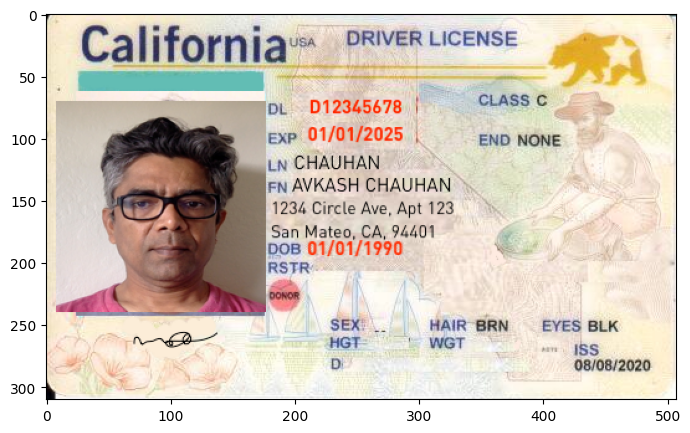

In [30]:
show_image_in_cell(face_id_path)

In [31]:
with open(face_id_path, mode="rb") as image_data:
    faces = face_client.face.detect_with_stream(
        image_data,
        detection_model="detection_03",
        recognition_model="recognition_04",
        return_face_attributes=["qualityForRecognition"],
    )

In [32]:
faces[0].face_rectangle.as_dict()

{'width': 81, 'height': 103, 'left': 57, 'top': 111}

In [33]:
# TAKEN FROM THE Azure SDK Sample
# Convert width height to a point in a rectangle
def getRectangle(faceDictionary):
    rect = faceDictionary.face_rectangle
    left = rect.left
    top = rect.top
    right = left + rect.width
    bottom = top + rect.height

    return ((left, top), (right, bottom))

In [34]:
def drawFaceRectangles(source_file, detected_face_object):
    # Download the image from the url
    # response = requests.get(source_file)
    img = Image.open(source_file)
    # Draw a red box around every detected faces
    draw = ImageDraw.Draw(img)
    for face in detected_face_object:
        draw.rectangle(getRectangle(face), outline="red", width=10)
    return img

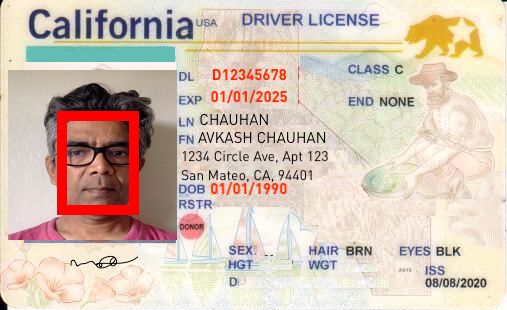

In [35]:
drawFaceRectangles(face_id_path, faces)

In [38]:
"""
Detect all faces in query image list, then add their face IDs to a new list.
"""


def detect_faces(client, query_images_list):
    print("Detecting faces in query images list...")

    face_ids = {}  # Keep track of the image ID and the related image in a dictionary
    for image_name in query_images_list:
        image = open(image_name, "rb")  # BufferedReader
        print("Opening image: ", image.name)
        time.sleep(5)

        # Detect the faces in the query images list one at a time, returns list[DetectedFace]
        faces = client.face.detect_with_stream(image)

        # Add all detected face IDs to a list
        for face in faces:
            print(
                "Face ID",
                face.face_id,
                "found in image",
                os.path.splitext(image.name)[0] + ".jpg",
            )
            # Add the ID to a dictionary with image name as a key.
            # This assumes there is only one face per image (since you can't have duplicate keys)
            face_ids[image.name] = face.face_id

    return face_ids


In [50]:
my_face_images = [file for file in glob.glob("*.png")]
print(my_face_images)


['ca-dl-avkash-chauhan.png', 'face1.png', 'face2.png', 'face3.png', 'face4.png', 'face5.png', 'face6.png', 'face7.png', 'videoanalyzer_screenshot.png']


In [51]:
ids = detect_faces(face_client, my_face_images)
verify_result = face_client.face.verify_face_to_face(
    ids["videoanalyzer_screenshot.png"], ids["ca-dl-avkash-chauhan.png"]
)
if verify_result.is_identical:
    print(
        "Faces are of the same (Positive) person, similarity confidence: {}.".format(
            verify_result.confidence
        )
    )
else:
    print(
        "Faces are of different (Negative) persons, similarity confidence: {}.".format(
            verify_result.confidence
        )
    )


Detecting faces in query images list...
Opening image:  ca-dl-avkash-chauhan.png
Face ID b1f7611a-0b91-416c-b3a5-7439d4ee092a found in image ca-dl-avkash-chauhan.jpg
Opening image:  face1.png
Face ID c649b289-4d7e-4135-9571-42d8ef2aac2c found in image face1.jpg
Opening image:  face2.png
Face ID 9fb991b7-b3a4-4341-8c02-b12a7173b325 found in image face2.jpg
Opening image:  face3.png
Face ID 93db712b-5660-40b2-8b56-7ffa520ff042 found in image face3.jpg
Opening image:  face4.png
Face ID a35b8e2a-fe9a-4da8-8029-664d80421ff1 found in image face4.jpg
Opening image:  face5.png
Face ID 75f43e32-8cde-4b2b-aff0-1aac1beeeb94 found in image face5.jpg
Opening image:  face6.png
Face ID c4363b66-9f40-4779-815c-410fad931bae found in image face6.jpg
Opening image:  face7.png
Face ID 84a998d2-368d-42f5-8c81-43231a49f6b9 found in image face7.jpg
Opening image:  videoanalyzer_screenshot.png
Face ID 7ab6a3be-7eb7-40b3-bfb9-ba2436f7897b found in image videoanalyzer_screenshot.jpg
Faces are of the same (Posit